# XGBoost on Predicting Stock Price

# Load the dataset

In [1]:
import pandas as pd
# Train Dataset
dataset_train = pd.read_csv("train.csv")
dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])
dataset_train = dataset_train[['Close']]
dataset_train.head()

,Close
0,1416.599976
1,1418.339966
2,1409.709961
3,1412.839966
4,1412.109985


In [2]:
# val Dataset
dataset_test = pd.read_csv("val.csv")
dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])
dataset_test = dataset_test[['Close']]
dataset_test.head()

,Close
0,2180.889893
1,2181.739990
2,2175.489990
3,2185.790039
4,2184.050049


# MinMaxNomalize on close price

In [3]:
def min_max_normalize(data):
    min_data = data.min(axis=0)
    max_data = data.max(axis=0)
    normalized_data = (data - min_data) / (max_data - min_data)
    return normalized_data

In [4]:
dataset_train_normalized = min_max_normalize(dataset_train)
dataset_train_normalized

,Close
0,0.491303
1,0.492458
2,0.486729
3,0.488807
4,0.488323
...,...
2411,0.992014
2412,0.982846
2413,0.987333
2414,0.987639


In [5]:
dataset_test_scaled = min_max_normalize(dataset_test)
dataset_test_scaled

,Close
0,0.101745
1,0.102649
2,0.096005
3,0.106955
4,0.105105
...,...
801,0.936524
802,0.967917
803,0.961549
804,0.970330


# Use a window of 20 days on close price

In [6]:
window = 21

In [7]:
import numpy as np
x_train = []
y_train = []
for index in range(len(dataset_train_normalized) - window):
    need_data = dataset_train_normalized[index: index + window]
    x_train.append(need_data.iloc[:-1])
    y_train.append(need_data.iloc[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

In [8]:
x_test = []
y_test = []
for index in range(len(dataset_test_scaled) - window):
    need_data = dataset_test_scaled[index: index + window]
    x_test.append(need_data.iloc[:-1])
    y_test.append(need_data.iloc[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [9]:
x_train.shape,y_train.shape

((2395, 20, 1), (2395, 1))

In [10]:
x_test.shape, y_test.shape

((785, 20, 1), (785, 1))

# Define a model: XGBoost

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin

class XGBoost_50(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=2, objective='reg:squarederror'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.objective = objective
        self.trees = []
        self.feature_importances_ = None

    def fit(self, X, y):
        if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
            raise ValueError("X and y must be numpy arrays")

        if X.ndim != 2:
            raise ValueError("X must be a 2D array")

        if len(X) != len(y):
            raise ValueError("Length of X and y must be the same")

        self.feature_importances_ = np.zeros(X.shape[1])
        y_pred = np.zeros_like(y, dtype=np.float64)
        for i in range(self.n_estimators):
            residual = y - y_pred
            tree = self._build_tree(X, residual, depth=0)
            update = self.learning_rate * tree.predict(X)
            y_pred += update
            self.trees.append(tree)
        self.feature_importances_ /= np.sum(self.feature_importances_)

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(X) <= 1:
            return LeafNode(self._calculate_leaf_value(y))

        feature_index, threshold = self._find_best_split(X, y)

        left_indices = X[:, feature_index] < threshold
        right_indices = ~left_indices
        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        left_tree = self._build_tree(left_X, left_y, depth + 1)
        right_tree = self._build_tree(right_X, right_y, depth + 1)

        return TreeNode(feature_index, threshold, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_feature_index = None
        best_threshold = None
        best_loss = float('inf')

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] < threshold
                right_indices = ~left_indices

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_y, right_y = y[left_indices], y[right_indices]

                loss = self._calculate_loss(left_y, right_y)
                if loss < best_loss:
                    best_loss = loss
                    best_feature_index = feature_index
                    best_threshold = threshold

        self.feature_importances_[best_feature_index] += best_loss

        return best_feature_index, best_threshold

    def _calculate_loss(self, left_y, right_y):
        if self.objective == 'reg:squarederror':
            left_loss = np.mean((left_y - np.mean(left_y)) ** 2)
            right_loss = np.mean((right_y - np.mean(right_y)) ** 2)
        elif self.objective == 'binary:logistic':
            left_prob = np.mean(left_y)
            left_loss = -left_prob * np.log(left_prob) - (1 - left_prob) * np.log(1 - left_prob)
            right_prob = np.mean(right_y)
            right_loss = -right_prob * np.log(right_prob) - (1 - right_prob) * np.log(1 - right_prob)
        else:
            raise ValueError(f"Objective {self.objective} not supported")

        total_loss = (len(left_y) * left_loss + len(right_y) * right_loss) / (len(left_y) + len(right_y))

        return total_loss

    def _calculate_leaf_value(self, y):
        if self.objective == 'reg:squarederror':
            return np.mean(y)
        elif self.objective == 'binary:logistic':
            prob = np.mean(y)
            return np.log(prob / (1 - prob))
        else:
            raise ValueError(f"Objective {self.objective} not supported")

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be a numpy array")

        if X.ndim != 2:
            raise ValueError("X must be a 2D array")

        y_pred = np.zeros(len(X))
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

class TreeNode:
    def __init__(self, feature_index, threshold, left_tree, right_tree):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_tree = left_tree
        self.right_tree = right_tree

    def predict(self, X):
        values = np.zeros(len(X))
        left_indices = X[:, self.feature_index] < self.threshold
        right_indices = ~left_indices
        values[left_indices] = self.left_tree.predict(X[left_indices])
        values[right_indices] = self.right_tree.predict(X[right_indices])
        return values

class LeafNode:
    def __init__(self, value):
        self.value = value

    def predict(self, X):
        return np.full(len(X), self.value)

In [12]:
class XGBoost_100(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.objective = objective
        self.trees = []
        self.feature_importances_ = None

    def fit(self, X, y):
        if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
            raise ValueError("X and y must be numpy arrays")

        if X.ndim != 2:
            raise ValueError("X must be a 2D array")

        if len(X) != len(y):
            raise ValueError("Length of X and y must be the same")

        self.feature_importances_ = np.zeros(X.shape[1])
        y_pred = np.zeros_like(y, dtype=np.float64)
        for i in range(self.n_estimators):
            residual = y - y_pred
            tree = self._build_tree(X, residual, depth=0)
            update = self.learning_rate * tree.predict(X)
            y_pred += update
            self.trees.append(tree)
        self.feature_importances_ /= np.sum(self.feature_importances_)

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(X) <= 1:
            return LeafNode(self._calculate_leaf_value(y))

        feature_index, threshold = self._find_best_split(X, y)

        left_indices = X[:, feature_index] < threshold
        right_indices = ~left_indices
        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        left_tree = self._build_tree(left_X, left_y, depth + 1)
        right_tree = self._build_tree(right_X, right_y, depth + 1)

        return TreeNode(feature_index, threshold, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_feature_index = None
        best_threshold = None
        best_loss = float('inf')

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] < threshold
                right_indices = ~left_indices

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_y, right_y = y[left_indices], y[right_indices]

                loss = self._calculate_loss(left_y, right_y)
                if loss < best_loss:
                    best_loss = loss
                    best_feature_index = feature_index
                    best_threshold = threshold

        self.feature_importances_[best_feature_index] += best_loss

        return best_feature_index, best_threshold

    def _calculate_loss(self, left_y, right_y):
        if self.objective == 'reg:squarederror':
            left_loss = np.mean((left_y - np.mean(left_y)) ** 2)
            right_loss = np.mean((right_y - np.mean(right_y)) ** 2)
        elif self.objective == 'binary:logistic':
            left_prob = np.mean(left_y)
            left_loss = -left_prob * np.log(left_prob) - (1 - left_prob) * np.log(1 - left_prob)
            right_prob = np.mean(right_y)
            right_loss = -right_prob * np.log(right_prob) - (1 - right_prob) * np.log(1 - right_prob)
        else:
            raise ValueError(f"Objective {self.objective} not supported")

        total_loss = (len(left_y) * left_loss + len(right_y) * right_loss) / (len(left_y) + len(right_y))

        return total_loss

    def _calculate_leaf_value(self, y):
        if self.objective == 'reg:squarederror':
            return np.mean(y)
        elif self.objective == 'binary:logistic':
            prob = np.mean(y)
            return np.log(prob / (1 - prob))
        else:
            raise ValueError(f"Objective {self.objective} not supported")

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be a numpy array")

        if X.ndim != 2:
            raise ValueError("X must be a 2D array")

        y_pred = np.zeros(len(X))
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

class TreeNode:
    def __init__(self, feature_index, threshold, left_tree, right_tree):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_tree = left_tree
        self.right_tree = right_tree

    def predict(self, X):
        values = np.zeros(len(X))
        left_indices = X[:, self.feature_index] < self.threshold
        right_indices = ~left_indices
        values[left_indices] = self.left_tree.predict(X[left_indices])
        values[right_indices] = self.right_tree.predict(X[right_indices])
        return values

class LeafNode:
    def __init__(self, value):
        self.value = value

    def predict(self, X):
        return np.full(len(X), self.value)

# Prepare the input sequence for XGBoost model

In [13]:
# Transform x_train converted to 2D form
x_train_2d = np.reshape(x_train, (2395, 20))
x_train_2d

array([[0.49130336, 0.49245847, 0.48672935, ..., 0.49397209, 0.49941572,
        0.50566932],
       [0.49245847, 0.48672935, 0.48880724, ..., 0.49941572, 0.50566932,
        0.51078101],
       [0.48672935, 0.48880724, 0.48832263, ..., 0.50566932, 0.51078101,
        0.51240752],
       ...,
       [0.93738461, 0.94480653, 0.94359161, ..., 0.99149591, 0.993846  ,
        0.99201374],
       [0.94480653, 0.94359161, 0.96483516, ..., 0.993846  , 0.99201374,
        0.98284578],
       [0.94359161, 0.96483516, 0.96965479, ..., 0.99201374, 0.98284578,
        0.98733349]])

In [14]:
# Remove excess dimensions
y_train = np.squeeze(y_train)
y_train = np.array(y_train)
y_train

array([0.51078101, 0.51240752, 0.5114781 , ..., 0.98284578, 0.98733349,
       0.98763884])

In [15]:
# Transform x_train converted to 2D form
x_test_2d = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))
x_test_2d

array([[0.10174549, 0.10264919, 0.09600506, ..., 0.09117873, 0.09108322,
        0.10077819],
       [0.10264919, 0.09600506, 0.10695464, ..., 0.09108322, 0.10077819,
        0.10768809],
       [0.09600506, 0.10695464, 0.10510492, ..., 0.10077819, 0.10768809,
        0.10734784],
       ...,
       [0.97856853, 0.97966352, 0.97972736, ..., 0.90673746, 0.94090437,
        0.93652444],
       [0.97966352, 0.97972736, 0.96407914, ..., 0.94090437, 0.93652444,
        0.96791665],
       [0.97972736, 0.96407914, 0.96377081, ..., 0.93652444, 0.96791665,
        0.96154892]])

In [16]:
# Remove excess dimensions
y_test = np.squeeze(y_test)
y_test = np.array(y_test)
y_test

array([0.10768809, 0.10734784, 0.10218151, 0.04531841, 0.07851777,
       0.04447855, 0.04314972, 0.06599488, 0.05738399, 0.05734168,
       0.05802193, 0.08285514, 0.09780157, 0.08452396, 0.06476183,
       0.07946378, 0.09162539, 0.07010879, 0.0883298 , 0.08081388,
       0.06942855, 0.07925122, 0.08035684, 0.07288349, 0.08342897,
       0.05480082, 0.05740527, 0.0503573 , 0.05081435, 0.04392574,
       0.05785193, 0.06283762, 0.05970165, 0.05951011, 0.07032161,
       0.06163623, 0.05767104, 0.05087819, 0.04382997, 0.04355356,
       0.02821367, 0.01356466, 0.00369943, 0.        , 0.04926232,
       0.05780937, 0.08300385, 0.08748994, 0.08426883, 0.08400307,
       0.10121395, 0.09754645, 0.10836859, 0.10281919, 0.12012584,
       0.12518602, 0.1270783 , 0.13625265, 0.12388912, 0.12701446,
       0.12079571, 0.11257827, 0.113503  , 0.12706766, 0.1350619 ,
       0.16601835, 0.17116339, 0.18534471, 0.18261258, 0.19830336,
       0.17870058, 0.18800236, 0.18379269, 0.1885339 , 0.19728

# Train the model

## Based on train dataset

In [17]:
xgb_train_model = XGBoost_50(n_estimators=50, learning_rate=0.1, max_depth=2, objective='reg:squarederror')

xgb_train_model.fit(x_train_2d, y_train)

C:\Users\may\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\may\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
from joblib import dump

# 假设模型对象为model
dump(xgb_train_model, 'xgb_train_model.joblib')

['xgb_train_model.joblib']

In [19]:
from joblib import load

xgb_train_model = load('xgb_train_model.joblib')

In [20]:
# 预测
y_train_pred = xgb_train_model.predict(x_train_2d)
y_train_pred

array([0.50695605, 0.50695605, 0.50695605, ..., 0.96537311, 0.96537311,
       0.96537311])

## Based on test dataset

In [22]:
xgb_test_model = XGBoost_100(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror')

xgb_test_model.fit(x_test_2d, y_test)

In [23]:
dump(xgb_test_model, 'xgb_test_model.joblib')

['xgb_test_model.joblib']

In [24]:
xgb_test_model = load('xgb_test_model.joblib')

In [25]:
y_test_pred = xgb_test_model.predict(x_test_2d)
y_test_pred

array([0.09880395, 0.10877304, 0.11014416, 0.07329475, 0.06802803,
       0.06180239, 0.05271107, 0.0558671 , 0.06042196, 0.05637968,
       0.05830135, 0.07944044, 0.08993717, 0.08312646, 0.07679133,
       0.07611177, 0.0819206 , 0.07112011, 0.08153116, 0.07939506,
       0.07640617, 0.07688586, 0.07632605, 0.07219275, 0.07502751,
       0.07217311, 0.06054837, 0.05682591, 0.05550868, 0.05550868,
       0.05153101, 0.06311657, 0.06618678, 0.06618678, 0.06618678,
       0.0668965 , 0.0638633 , 0.05262007, 0.0491348 , 0.04707581,
       0.03501601, 0.01950229, 0.01561478, 0.01561478, 0.04118771,
       0.05876042, 0.07445308, 0.08088052, 0.08358191, 0.08334753,
       0.09273836, 0.09611979, 0.09713517, 0.10638178, 0.11633503,
       0.12045172, 0.12355754, 0.13126942, 0.12850581, 0.12156803,
       0.12229444, 0.12156803, 0.1157228 , 0.12950714, 0.13640847,
       0.16979897, 0.16979897, 0.17876484, 0.18484284, 0.18682777,
       0.18589344, 0.18653574, 0.18589344, 0.18589344, 0.19608

# Evaluate the model

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 计算预测误差的平方
squared_errors = (y_train - y_train_pred) ** 2

# 计算均方误差
mse = np.mean(squared_errors)
print("Mean Squared Error (MSE):", mse)

# 计算均方根误差（RMSE）
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_train, y_train_pred)
print("Mean Absolute Error (MAE):", mae)

# 计算决定系数（R²）
r2 = r2_score(y_train, y_train_pred)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.00012979651863143327
Root Mean Squared Error (RMSE): 0.011392827508192743
Mean Absolute Error (MAE): 0.008681477709034041
R-squared (R²): 0.9979372979721022


In [27]:
# Calculate the square of prediction error
squared_errors_test = (y_test - y_test_pred) ** 2

# Calculate mean square error
mse_test = np.mean(squared_errors_test)
print("Mean Squared Error (MSE):", mse_test)

# Calculate root mean square error（RMSE）
rmse_test = np.sqrt(mse_test)
print("Root Mean Squared Error (RMSE):", rmse_test)

# Calculate the average absolute error（MAE）
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error (MAE):", mae_test)

# Calculate the coefficient of determination（R²）
r2_test = r2_score(y_test, y_test_pred)
print("R-squared (R²):", r2_test)

Mean Squared Error (MSE): 0.00018907576488351143
Root Mean Squared Error (RMSE): 0.013750482350939964
Mean Absolute Error (MAE): 0.010000018105281255
R-squared (R²): 0.9972389329770913


# XGBoost model of train dataset to predict val dataset

In [28]:
# Val Data
dataset_val = pd.read_csv("val.csv")
dataset_val['Date'] = pd.to_datetime(dataset_val['Date'])
dataset_val = dataset_val[['Close']]
dataset_val.head()

,Close
0,2180.889893
1,2181.739990
2,2175.489990
3,2185.790039
4,2184.050049


In [29]:
dataset_val_normalized = min_max_normalize(dataset_val)
dataset_val_normalized

,Close
0,0.101745
1,0.102649
2,0.096005
3,0.106955
4,0.105105
...,...
801,0.936524
802,0.967917
803,0.961549
804,0.970330


In [30]:
x_val = []
y_val = []
for index in range(len(dataset_val_normalized) - window):
    need_data = dataset_val_normalized[index: index + window]
    x_val.append(need_data.iloc[:-1])
    y_val.append(need_data.iloc[-1])
x_val = np.array(x_val)
y_val = np.array(y_val)
x_val_2d = np.reshape(x_val, (785, 20))
y_val = np.squeeze(y_val)
y_val = np.array(y_val)

In [31]:
# 预测
y_val_pred = xgb_train_model.predict(x_val_2d)

# Visualization

In [32]:
min_1 = dataset_train.min()[0]
max_1 = dataset_train.max()[0]
y_train_o = pd.DataFrame(y_train)*(max_1-min_1)+min_1
y_train_pred_o = pd.DataFrame(y_train_pred)*(max_1-min_1)+min_1
min_2 = np.min(dataset_val,axis=0)[0]
max_2 = np.max(dataset_val,axis=0)[0]
y_val_o = pd.DataFrame(y_val)*(max_2-min_2)+min_2
y_val_pred_o = pd.DataFrame(y_val_pred)*(max_2-min_2)+min_2
min_3 = dataset_test.min()[0]
max_3 = dataset_test.max()[0]
y_test_o = pd.DataFrame(y_test)*(max_3-min_3)+min_3
y_test_pred_o = pd.DataFrame(y_test_pred)*(max_3-min_3)+min_3

In [33]:
N_val = 2395
# 将索引加上一个值
new_index = y_val_o.index.map(lambda x: x + N_val)
y_val_o.index = new_index
y_val_pred_o.index = new_index

<Figure size 2400x1600 with 0 Axes>

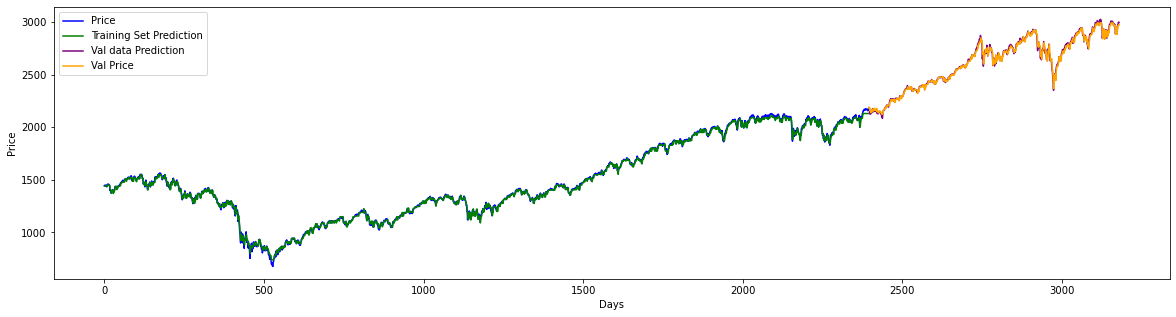

In [34]:
import matplotlib.pyplot as plt

## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 5))
plt.plot(y_train_o, color = 'blue', label = 'Price')
plt.plot(y_train_pred_o, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(y_val_o, color = 'purple', label = 'Val data Prediction')
plt.plot(y_val_pred_o, color = 'orange', label = 'Val Price')
plt.legend()
plt.savefig("Val-Result1.png", dpi=500)
plt.show()

<Figure size 2400x1600 with 0 Axes>

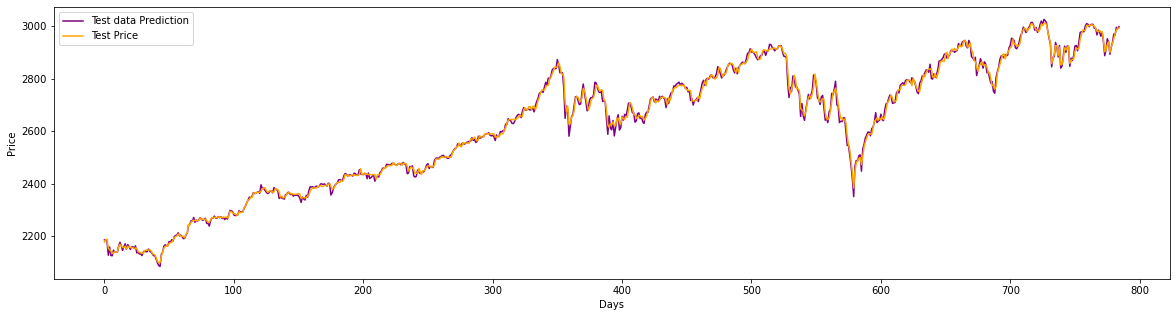

In [35]:
## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 5))
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(y_test_o, color = 'purple', label = 'Test data Prediction')
plt.plot(y_test_pred_o, color = 'orange', label = 'Test Price')
plt.legend()
plt.savefig("Test-Result1.png", dpi=500)
plt.show()

# Backtest

In [36]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    """
    Backtest function to simulate trading based on the model's predictions.

    :param predictions: The predicted prices from the model.
    :param original_prices: The actual prices of the stock.
    :param threshold: The threshold for making a trade decision.
    :param initial_cash: The initial cash in the portfolio.
    :return: The final portfolio value and the total return.
    """
    cash = initial_cash
    shares = 0
    total_assets = initial_cash

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        # Decision to buy
        if predicted_change > threshold and cash >= original_prices[i]:
            shares_bought = cash // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]

        # Decision to sell
        elif predicted_change < -threshold and shares > 0:
            cash += shares * original_prices[i]
            shares = 0

        # Update total assets value
        total_assets = cash + shares * original_prices[i]

    total_return = total_assets - initial_cash
    return total_assets, total_return

## train backtest

In [37]:
y_train_list = y_train_o[0].tolist()
y_train_pred_list = y_train_pred_o[0].tolist()

In [38]:
initial_cash = 500000
threshold = 0.015
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return = backtest(y_train_pred_list, y_train_list, threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 1360275.2352294922 Total Return: 860275.2352294922 Return Rate: 172.05504704589845


## val backtest

In [39]:
y_val_list = y_val_o[0].tolist()
y_val_pred_list = y_val_pred_o[0].tolist()

In [40]:
initial_cash = 500000
threshold = 0.015
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return = backtest(y_val_pred_list, y_val_list, threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 718152.0346679688 Total Return: 218152.03466796875 Return Rate: 43.630406933593754


## test backtest

In [41]:
y_test_list = y_test_o[0].tolist()
y_test_pred_list = y_test_pred_o[0].tolist()

In [42]:
initial_cash = 500000
threshold = 0.015
# Applying the backtest function to the model's predictions
final_assets, total_return = backtest(y_test_pred_list, y_test_list, threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 761118.734375 Total Return: 261118.734375 Return Rate: 52.223746874999996


# Parameter Tuning Code

## train dataset

In [ ]:
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# define the search space
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01,0.05, 0.1],
    'max_depth': [2, 3, 4],
    'objective': ['reg:squarederror']
}

# create model and cross-validation objects
xgb_model = XGBoost()
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=3, verbose=2)

# perform cross-validation
grid_search.fit(x_train_2d, y_train)

# output the best parameters and corresponding model performance
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE found: ", np.sqrt(-grid_search.best_score_))

## test dataset

In [ ]:
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# define the search space
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'objective': ['reg:squarederror']
}

# create model and cross-validation objects
grid_search = GridSearchCV(xgb_test_model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=3, verbose=2)

# perform cross-validation
grid_search.fit(x_test_2d, y_test)

# output the best parameters and corresponding model performance
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE found: ", np.sqrt(-grid_search.best_score_))